<a href="https://colab.research.google.com/github/lhrkkk/LFP/blob/main/all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Global Settings


## Global Variables

In [149]:
### @title Global Variables {display-mode: "form"}

# 全局参数
# DATA_SOURCE='real'
DATA_SOURCE='synth'

# FIND_HIGHLIGHT=True
# SIMULATION_EVENTS=False

FIND_HIGHLIGHT=False
SIMULATION_EVENTS=True

# TFR 频率范围
fmin=5.
fmax=100.

# Event 窗口前后宽度
tmin=-1
tmax=1

# 聚类方法, Kmeans, TimeSeriesKmeans_DTW, DBSCAN, ward
algorithm='kmeans'
# algorithm='tsdtw'
# algorithm='dbscan'
# algorithm='ward'


## 流程
1. 时频域图-》寻找高光活跃中心点-》将这些点，按频率划分到时间点集合

2. 对某一频率的时间点集，进行原始片段提取，并在此频率滤波后 -》普通聚类或 DTW距离聚类。

3. 返还到原信号时间片，对比类内样本的滤波后的波形。

这样能得到某一频率的活跃波形。并且能够按照相似性聚集类别。

In [150]:
#@title Dependences {display-mode: "form"}
# 加上这一行可折叠代码

# %%script false --no-raise-error  
# 加上这一行可以禁止 cell 运行

!pip install numpy matplotlib mne pandas PyWavelets scikit-learn tslearn yapf scipy imageio opencv-python numba dtaidistance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [151]:
import numpy as np
from matplotlib import pyplot as plt

from mne import create_info, Epochs
from mne.baseline import rescale
from mne.io import RawArray
from mne.time_frequency import (tfr_multitaper, tfr_stockwell, tfr_morlet,
                                tfr_array_morlet, AverageTFR)
from mne.viz import centers_to_edges
import scipy.stats as stats

from sklearn.cluster import AgglomerativeClustering 
import pandas as pd
import matplotlib.pyplot as plt
# from scipy.cluster.hierarchy import linkage,dendrogram


from sklearn.cluster import KMeans,DBSCAN
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from tslearn.clustering import TimeSeriesKMeans
# from dtaidistance import dtw
# dist_dtai = dtw.distance_fast(a[0], a[1])

# parms = {
#     "quantile": 0.3,
#     "eps": 0.3,
#     "damping": 0.9,
#     "preference": -200,
#     "n_neighbors": 3,
#     "n_clusters": 3,
#     "min_samples": 7,
#     "xi": 0.05,
#     "min_cluster_size": 0.1,
# }
print(__doc__)


Automatically created module for IPython interactive environment


In [152]:
#@title Hepers {display-mode: "form"}

import sys
def var_from_name(name):
  return sys._getframe().f_back.f_locals[name]
  

# Source Data

In [153]:
#@title Real data {display-mode: "form"}

# %%script false --no-raise-error  # 真实信号
# 加上这一行可以禁止 cell 运行

if DATA_SOURCE=='real':

  ## 设定 Epoches 基本参数
  sfreq = 1250.0
  # ch_names = ['SIM0001', 'SIM0002']
  # ch_types = ['grad', 'grad']
  ch_names = ['LFP1']
  ch_types = ['seeg']  # 设定信号类型，会改变单位值
  info = create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
  epoch_real_time=10
  n_times = epoch_real_time*sfreq
  n_epochs = 40

  # real data
  import scipy.io as scio
  dataFile = 'VRlfp75.mat'

  data = scio.loadmat(dataFile)
  # channel0
  data=list(data['LFP_data']['lfp_ncs'][0][0].flatten())

  # 去掉末尾 0 值
  while data[-1]==0:
      del data[-1]

  # 标准化，其实不需要，MNE 会自动标准化
  data=np.array([data])
  data[0]=stats.zscore(data[0])


In [154]:
#@title Synth data {display-mode: "form"}

# %%script false --no-raise-error # 模拟信号

if DATA_SOURCE=='synth':

  ## 设定 Epoches 基本参数
  sfreq = 1000.0
  # ch_names = ['SIM0001', 'SIM0002']
  # ch_types = ['grad', 'grad']
  ch_names = ['SIM0001']
  ch_types = ['seeg']  # 设定信号类型，会改变单位值
  info = create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
  n_times = 4024  # Just over 1 second epochs
  n_epochs = 1

  seed = 42
  rng = np.random.RandomState(seed)
  data = rng.randn(len(ch_names), n_times * n_epochs + 200)  # buffer

  # Add a 50 Hz sinusoidal burst to the noise and ramp it.  加入50Hz的正弦脉冲
  t = np.arange(n_times, dtype=np.float64) / sfreq
  signal = 10*np.sin(np.pi * 2. * 50. * t)  # 50 Hz sinusoid signal
  # print(signal)
  signal[np.logical_or(t < 0.45, t > 0.55)] = 0.  # Hard windowing
  on_time = np.logical_and(t >= 0.45, t <= 0.55)
  # print(on_time)
  signal[on_time] *= np.hanning(on_time.sum())  # Ramping
  data[:, 100:-100] += np.tile(signal, n_epochs)  # add signal
data

array([[ 0.49671415, -0.1382643 ,  0.64768854, ...,  0.84477438,
        -0.00556029,  1.17851269]])

In [155]:
# 读取 data 数据到 raw 变量，进入 MNE 处理流程
raw = RawArray(data, info)

Creating RawArray with float64 data, n_channels=1, n_times=4224
    Range : 0 ... 4223 =      0.000 ...     4.223 secs
Ready.


In [156]:
#@title (bandpass filter) {display-mode: "form"}
# bandpass filter
# fmin=0
# fmax=60
raw.filter(fmin, fmax, n_jobs=None,  # use more jobs to speed up.
               l_trans_bandwidth=1,  # make sure filter params are the same
               h_trans_bandwidth=1)  # in each band and skip "auto" option.


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 4.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 100.50 Hz)
- Filter length: 3301 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


<RawArray | 1 x 4224 (4.2 s), ~40 kB, data loaded>

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Need more than one channel to make topography for seeg. Disabling interactivity.


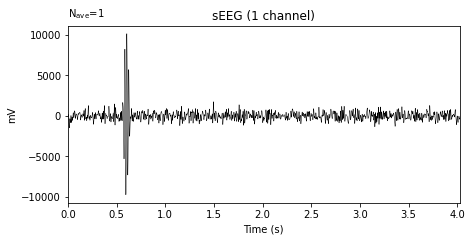

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Using data from preloaded Raw for 1 events and 4025 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Need more than one channel to make topography for seeg. Disabling interactivity.
1


<ipython-input-157-c0efb8cb9eaa>:22: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs.plot_psd()


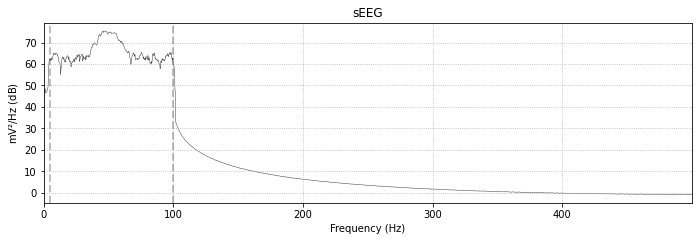

In [157]:
# %%script false --no-raise-error  # 模拟信号生成 Events 和 Epoches

if DATA_SOURCE=='synth':

  # event 是一个三元组(first_sample, ,event_code), 标记一个事件的（该事件起始时间采样点，，事件类型编号）
  # events 是一系列 event 的列向量
  events = np.zeros((n_epochs, 3), dtype=int)
  events[:, 0] = np.arange(n_epochs) * n_times

  # epoch 是根据 event 截取的片段，其中 tmin，tmax 是 first_sample 前后的偏移量
  # epoches 是一系列 epoch，也就是一系列事件截取的等长片段集合
  epochs = Epochs(raw, events, dict(sin50hz=0), tmin=0, tmax=n_times / sfreq,
                  reject=dict(seeg=4000), 
                  baseline=None)


  # 这里是对所有 epoches 取平均，模拟信号生成的时候是每个 epoch 中 event 是相同的，所以能够很好的平均。平均用于去掉噪声。
  # 但是如果是我们自己的真实信号，由于没有 event 的数据，平均会乱掉，所以不用平均，也不用切那么小的片段。
  epochs.average().plot()

  # 可以画出频率谱看一下
  epochs.plot_psd()
  # for i in range(n_epochs):
      # epochs[i].average().plot()

  # print(events)
# print(events)
print(n_epochs)


In [158]:
#%%script false --no-raise-error # 真实信号生成 Events 和 Epoches

if DATA_SOURCE=='real':

  # event 是一个三元组(first_sample, ,event_code), 标记一个事件的（该事件起始时间采样点，，事件类型编号）
  # events 是一系列 event 的列向量
  events = np.zeros((n_epochs, 3), dtype=int)
  events[:, 0] = np.arange(n_epochs) * n_times

  # epoch 是根据 event 截取的片段，其中 tmin，tmax 是 first_sample 前后的偏移量
  # epoches 是一系列 epoch，也就是一系列事件截取的等长片段集合
  epochs = Epochs(raw, events, 0, tmin=0, tmax=n_times / sfreq,
                  # reject=dict(seeg=4000), 
                  baseline=None)


  # 这里是对所有 epoches 取平均，模拟信号生成的时候是每个 epoch 中 event 是相同的，所以能够很好的平均。平均用于去掉噪声。
  # 但是如果是我们自己的真实信号，由于没有 event 的数据，平均会乱掉，所以不用平均，也不用切那么小的片段。
  epochs.average().plot()
  # 可以画出频率谱看一下
  epochs.plot_psd()
  # for i in range(n_epochs):
      # epochs[i].average().plot()



# 模拟信号

array([[[10.        ,  1.68699997, 58.        ],
        [ 4.        ,  1.84472643, 26.        ],
        [10.        ,  1.74898021, 66.        ]],

       [[ 8.        ,  0.33446436, 40.        ],
        [ 4.        ,  0.33125583, 93.        ],
        [ 7.        ,  0.81486809, 77.        ]],

       [[10.        ,  0.33568424, 31.        ],
        [ 2.        ,  0.27076485, 91.        ],
        [ 1.        ,  1.23085633, 84.        ]]])

[0.8942112441624084,
 1.9614206443341176,
 2.604051965170602,
 2.9627866448862115,
 3.4070670186455674,
 3.7507926039287973,
 4.486863988341794,
 5.247177495037691,
 5.745869524777428,
 5.962488119498551,
 6.472256556558806,
 6.68714455770907,
 7.1941086142822215,
 7.54208654801494,
 7.855424824680739,
 8.095136241636197,
 8.32362209197004,
 8.992011109762352,
 9.281584140792104,
 9.541996422442518]

Creating RawArray with float64 data, n_channels=1, n_times=10200
    Range : 0 ... 10199 =      0.000 ...    10.199 secs
Ready.
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Need more than one channel to make topography for seeg. Disabling interactivity.


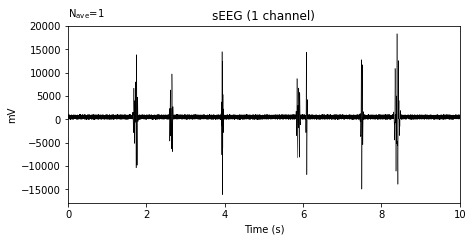

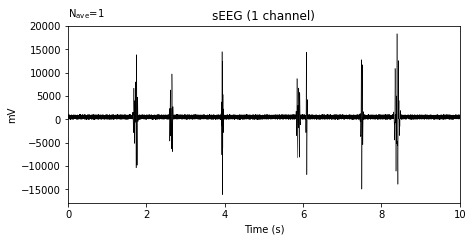

In [171]:
## 设定 Epoches 基本参数
sfreq = 1000.0 #1s的采样点数目
all_time = 10 #采样秒数
# ch_names = ['SIM0001', 'SIM0002']
# ch_types = ['grad', 'grad']
ch_names = ['SIM0001']
ch_types = ['seeg']  # 设定信号类型，会改变单位值
info = create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
n_times = sfreq*all_time  # Just over 1 epochs 一个epochs的采样数目 10S
n_epochs = 1 #epochs数目

import random
#生成sin的种类参数
sin_parameters = np.zeros((3,3,3)) #三个种类波的参数 [[[振幅，相位，频率],[振幅，相位，频率],[振幅，相位，频率]]]
ampltiude_range = [1,10]
freq_range = [20,100]
for wave_type in range(3):
    for sin_type in range(3):
        sample_type = np.array([random.randint(ampltiude_range[0], ampltiude_range[1]), random.uniform(0.,2.), random.randint(freq_range[0], freq_range[1])])
        sin_parameters[wave_type][sin_type] = sample_type
sin_parameters

#生成信号
import time
import datetime
seed = int(time.time())
rng = np.random.RandomState(seed)
# data = rng.randn(len(ch_names), int(n_times) * n_epochs)  # 正态分布的背景buffer
data = rng.rand(len(ch_names), int(n_times) * n_epochs + 200)  # 正态分布的背景buffer

t = np.arange(n_times, dtype=np.float64) / sfreq
max_time_len = 0.2 #插入信号最长的长度s
min_time_len = 0.05 #插入信号最短长度
n_wave = 20 #插入波片段的数量

#生成信号插入位置
locs = sorted(np.random.rand(n_wave+1)*all_time)
while len([i for index,i in enumerate(locs) if index>0 and i-locs[index-1]>=max_time_len])<n_wave:
#     print(len([i for index,i in enumerate(locs) if index>0 and i-locs[index-1]>=min_time_len]))
    locs = sorted(np.random.rand(n_wave+1)*all_time)

locs = locs[0:-1]
locs


#生成type1 type2 type3,并在随机位置混入
t = np.arange(n_times, dtype=np.float64) / sfreq
final_signal = np.zeros(int(n_times))
for i in range(3):
    type_parameters = sin_parameters[i]
    res_type = np.zeros(int(n_times))
    for parameter in  type_parameters:
        res_type += parameter[0]*np.sin(np.pi * 2. * parameter[2] * t + parameter[1]*np.pi * 2.)
    ##在locs中随机选取位置插入
    if i == 0:
        n_type = 5
        random.shuffle(locs)
        loc = locs[:n_type]
        locs = locs[n_type:]
        for begin in loc:
            signal = res_type.copy()
            wave_len = random.uniform(min_time_len, max_time_len)
            end = begin+wave_len
            signal[np.logical_or(t <begin, t >end )] = 0.
            on_time = np.logical_and(t >=  begin, t <= end)
            signal[on_time] *= np.hanning(on_time.sum())  # Ramping
            final_signal += signal
    if i == 1:
        n_type = 10
        random.shuffle(locs)
        loc = locs[:n_type]
        locs = locs[n_type:]
        for begin in loc:
            signal = res_type
            wave_len = random.uniform(min_time_len, max_time_len)
            end = begin+wave_len
            signal[np.logical_or(t <begin, t >end )] = 0.
            on_time = np.logical_and(t >=  begin, t <= end)
            signal[on_time] *= np.hanning(on_time.sum())  # Ramping
            final_signal += signal
    if i == 2:
        n_type = 5
        random.shuffle(locs)
        loc = locs[:n_type]
        locs = locs[n_type:]
        for begin in loc:
            signal = res_type
            wave_len = random.uniform(min_time_len, max_time_len)
            end = begin+wave_len
            signal[np.logical_or(t <begin, t >end )] = 0.
            on_time = np.logical_and(t >=  begin, t <= end)
            signal[on_time] *= np.hanning(on_time.sum())  # Ramping
            final_signal += signal

data[:, 100:-100] += np.tile(final_signal, n_epochs)  # add signal np.tile扩展数组  从第100个采样点开始

# 读取 data 数据到 raw 变量，进入 MNE 处理流程
raw = RawArray(data, info)
# 模拟信号生成 Events 和 Epoches
# event 是一个三元组(first_sample, ,event_code), 标记一个事件的（该事件起始时间采样点，，事件类型编号）
# events 是一系列 event 的列向量
events = np.zeros((n_epochs, 3), dtype=int)
events[:, 0] = np.arange(n_epochs) * n_times

# epoch 是根据 event 截取的片段，其中 tmin，tmax 是 first_sample 前后的偏移量
# epoches 是一系列 epoch，也就是一系列事件截取的等长片段集合
epochs = Epochs(raw, events, dict(sin50hz=0), tmin=0, tmax=n_times / sfreq,
                reject=dict(seeg=4000), 
                baseline=None)


# 这里是对所有 epoches 取平均，模拟信号生成的时候是每个 epoch 中 event 是相同的，所以能够很好的平均。平均用于去掉噪声。
# 但是如果是我们自己的真实信号，由于没有 event 的数据，平均会乱掉，所以不用平均，也不用切那么小的片段。
epochs.average().plot()

# Draw TFR

Using data from preloaded Raw for 1 events and 10001 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


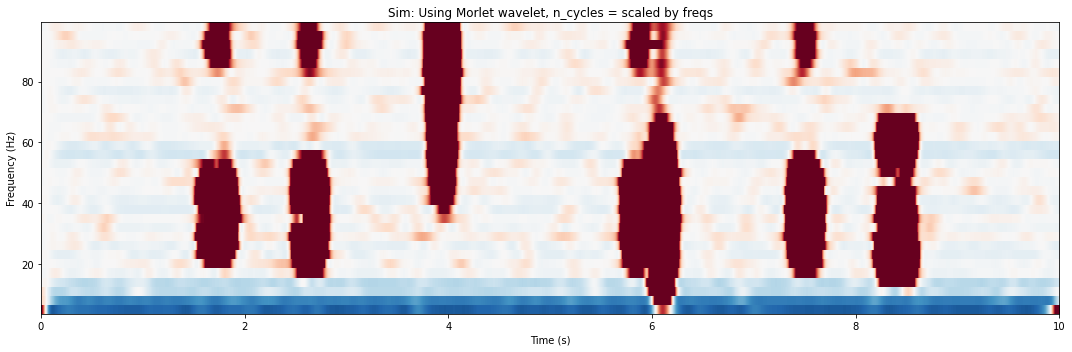

In [172]:
# %%script false --no-raise-error  # 画时频图，一张
fmin=5.
fmax=100.
freqs = np.arange(fmin, fmax, 3.)
# print(freqs)
vmin, vmax = -3., 3.  # Define our color limits.

fig, axs = plt.subplots(1, 1, figsize=(15, 5), sharey=True)
# all_n_cycles = [1, 3, freqs / 2.]
# all_n_cycles = [freqs / 2.,freqs / 2.,freqs / 3.,freqs / 4.,freqs / 5.,]
all_n_cycles = [freqs / 2.]
# print(all_n_cycles)
# print(axs)
for n_cycles, ax in zip(all_n_cycles, [axs]):
    power = tfr_morlet(epochs, freqs=freqs,
                       n_cycles=n_cycles, return_itc=False,
                    #    average=False
                       )
    power.plot([0], baseline=(0., 0.1), mode='mean', vmin=vmin, vmax=vmax,
               axes=ax, show=False, colorbar=False)
    n_cycles = 'scaled by freqs' if not isinstance(n_cycles, int) else n_cycles
    ax.set_title(f'Sim: Using Morlet wavelet, n_cycles = {n_cycles}')
plt.tight_layout()
# all_n_cycles
plt.savefig('output.png')


# Find Hightlights

In [173]:
#@title Functions: Define find highlights functions{display-mode: "form"}
# 定义寻找高光点的函数，内有参数可调。
# find highlight
import scipy.ndimage as ndimg
import numpy as np
from numba import jit
import cv2

def neighbors(shape):
    dim = len(shape)
    block = np.ones([3] * dim)
    block[tuple([1] * dim)] = 0
    idx = np.where(block > 0)
    idx = np.array(idx, dtype=np.uint8).T
    idx = np.array(idx - [1] * dim)
    acc = np.cumprod((1,) + shape[::-1][:-1])
    return np.dot(idx, acc[::-1])


@jit  # trans index to r, c...

def idx2rc(idx, acc):
    rst = np.zeros((len(idx), len(acc)), dtype=np.int16)
    for i in range(len(idx)):
        for j in range(len(acc)):
            rst[i, j] = idx[i] // acc[j]
            idx[i] -= rst[i, j] * acc[j]
    return rst


#@jit  # fill a node (may be two or more points)

def fill(img, msk, p, nbs, buf):
    msk[p] = 3
    buf[0] = p
    back = img[p]
    cur = 0
    s = 1
    while cur < s:
        p = buf[cur]
        for dp in nbs:
            cp = p + dp
            if img[cp] == back and msk[cp] == 1:
                msk[cp] = 3
                buf[s] = cp
                s += 1
                if s == len(buf):
                    buf[:s - cur] = buf[cur:]
                    s -= cur
                    cur = 0
        cur += 1
    #msk[p] = 3


#@jit  # my mark

def mark(img, msk, buf, mode):  # mark the array use (0, 1, 2)
    omark = msk
    nbs = neighbors(img.shape)
    idx = np.zeros(1024 * 128, dtype=np.int64)
    img = img.ravel()  # 降维
    msk = msk.ravel()  # 降维
    s = 0
    for p in range(len(img)):
        if msk[p] != 1: continue
        flag = False
        for dp in nbs:
            if mode and img[p + dp] > img[p]:
                flag = True
                break
            elif not mode and img[p + dp] < img[p]:
                flag = True
                break

        if flag : continue
        else    : fill(img, msk, p, nbs, buf)
        idx[s] = p
        s += 1
        if s == len(idx): break
    plt.imshow(omark, cmap='gray')
    return idx[:s].copy()



def filter(img, msk, idx, bur, tor, mode):
    omark = msk
    nbs = neighbors(img.shape)
    acc = np.cumprod((1,) + img.shape[::-1][:-1])[::-1]
    img = img.ravel()
    msk = msk.ravel()

    arg = np.argsort(img[idx])[::-1 if mode else 1]

    for i in arg:
        if msk[idx[i]] != 3:
            idx[i] = 0
            continue
        cur = 0
        s = 1
        bur[0] = idx[i]
        while cur < s:
            p = bur[cur]
            if msk[p] == 2:
                idx[i] = 0
                break

            for dp in nbs:
                cp = p + dp
                if msk[cp] == 0 or cp == idx[i] or msk[cp] == 4: continue
                if mode and img[cp] < img[idx[i]] - tor: continue
                if not mode and img[cp] > img[idx[i]] + tor: continue
                bur[s] = cp
                s += 1
                if s == 1024 * 128:
                    cut = cur // 2
                    msk[bur[:cut]] = 2
                    bur[:s - cut] = bur[cut:]
                    cur -= cut
                    s -= cut

                if msk[cp] != 2: msk[cp] = 4
            cur += 1
        msk[bur[:s]] = 2
        #plt.imshow(omark, cmap='gray')

    return idx2rc(idx[idx > 0], acc)


def find_maximum(img, tor, mode=True):
    msk = np.zeros_like(img, dtype=np.uint8)
    msk[tuple([slice(1, -1)] * img.ndim)] = 1
    buf = np.zeros(1024 * 128, dtype=np.int64)
    omark = msk
    idx = mark(img, msk, buf, mode)
    plt.imshow(msk, cmap='gray')
    idx = filter(img, msk, idx, buf, tor, mode)
    return idx

# 寻找坐标框
def getBigestTriangle(img):
    contours,hierarchy = cv2.findContours(img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)  #寻找轮廓点
    bigest_loc = []
    bigest_area = 0
    for obj in contours:
        area = cv2.contourArea(obj)  #计算轮廓内区域的面积
        perimeter = cv2.arcLength(obj,True)  #计算轮廓周长
        approx = cv2.approxPolyDP(obj,0.02*perimeter,True)  #获取轮廓角点坐标
        CornerNum = len(approx)   #轮廓角点的数量
        if area>bigest_area:
            bigest_area = area
            bigest_loc = approx
    if bigest_area>0:
#         return img[loc1[0][1]:loc2[0][1],loc1[0][0]:loc2[0][0]]
        return bigest_loc
    else:
        return None

# 寻找高光点主函数
def find_highlight(filepath):
 # from scipy.misc import imread
    from imageio import imread
    from scipy.ndimage import gaussian_filter
    from time import time
    import matplotlib.pyplot as plt

    img = cv2.imread(filepath)
    imgContour = img.copy()
    imgGray = cv2.cvtColor(imgContour,cv2.COLOR_RGB2GRAY)  #转灰度图
    imgBlur = cv2.GaussianBlur(imgGray,(5,5),1)  #高斯模糊
    imgCanny = cv2.Canny(imgBlur,60,60)  #Canny算子边缘检测
    locs = getBigestTriangle(imgCanny)  #坐标框
    locs = locs.reshape(locs.shape[0],-1)
    tem = sorted(locs,key = lambda x:x[1])
    tem = [x for x in tem if x[1]<tem[0][1]+5]
    tem = sorted(tem, key=lambda x:x[0]+x[1])
    left_up = tem[0]
    tem1 = sorted(locs,key = lambda x:x[0],reverse=True)
    tem1 = [x for x in tem1 if x[0]>tem1[0][0]-5]
    tem1 = sorted(tem1, key=lambda x:x[0]+x[1], reverse=True)
    right_down = tem1[0]
    img = img[left_up[1]:right_down[1],left_up[0]:right_down[0]]
    print(left_up,right_down)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.bitwise_not(img) # invert color
    ret2, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img[:] = ndimg.distance_transform_edt(img)
    plt.imshow(img, cmap='gray')
    start = time()
    pts = find_maximum(img, 15, True)  ######### 这个参数可调识别阈值
    print(time() - start)
    print(pts)
    plt.imshow(img, cmap='gray')
    plt.plot(pts[:, 1], pts[:, 0], 'y.')
    plt.show()
    return img,pts

## Find Highlight

[43 27] [1064  322]
12.252026796340942
[[ 16 402]
 [169 176]
 [169 269]
 [180 765]
 [207 609]
 [229 857]]


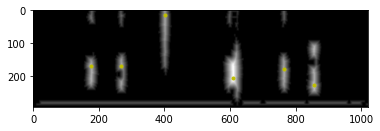

[[94.57627119  3.93731636]
 [42.71186441  1.7238002 ]
 [42.71186441  2.63467189]
 [38.98305085  7.49265426]
 [29.83050847  5.96474045]
 [22.37288136  8.39373164]]
(295, 1021)


10.0

In [174]:
# %%script false --no-raise-error
# if FIND_HIGHLIGHT==True:
if 1:
  # find_highlight('output.png')
    img,pts =  find_highlight('output.png')
    orignal_loc = []
    orignal_scale = [100, n_times / sfreq]
    for pt in pts:
        orignal_loc.append(pt/img.shape*orignal_scale)
    orignal_loc = np.array(orignal_loc)
    orignal_loc[:,0] = 100 - orignal_loc[:,0]  #因为处理完后的纵坐标是倒着的
print(orignal_loc)
# print(pts)

print(img.shape)
n_times / sfreq

In [185]:
#@title 【这里加入聚类，并变换到下面格式】 {display-mode: "form"}
# 单词拼错
print(orignal_loc)
source=orignal_loc[:,1].reshape(-1,1)
print(source)
kmeans = KMeans(n_clusters=3, random_state=666)
y_pre = kmeans.fit_predict(source)
print(y_pre)
print(np.unique(y_pre))
for i, sample in enumerate():
    


[[94.57627119  3.93731636]
 [42.71186441  1.7238002 ]
 [42.71186441  2.63467189]
 [38.98305085  7.49265426]
 [29.83050847  5.96474045]
 [22.37288136  8.39373164]]
[[3.93731636]
 [1.7238002 ]
 [2.63467189]
 [7.49265426]
 [5.96474045]
 [8.39373164]]
[0 1 1 2 0 2]
[0 1 2]


## Generate Events

In [131]:
# package found highlights to Events
if SIMULATION_EVENTS==False:

  type_freq_range=[[40,45],[50,60],[60,80]]  # 单位 Hz
  freqs_times=np.array([[3,4,5,],[9,10,11],[6,7,8]])*sfreq  # 单位 s
  type_id=[0,1,2]



In [132]:
# simulation events
if SIMULATION_EVENTS==True:
  times=np.array([1.5,2.5,40,50,60,70,80,90,100]) # 单位 s
  sample_times=times*sfreq #换算成 sample
  n_epochs=len(times)

  # event 是一个三元组(first_sample, ,event_code), 标记一个事件的（该事件起始时间采样点，，事件类型编号）
  # events 是一系列 event 的列向量
  events = np.zeros((n_epochs, 3), dtype=int)
  events[:, 0] = sample_times
  # events

In [133]:
# epoch 是根据 event 截取的片段，其中 tmin，tmax 是 first_sample 前后的偏移量
# epoches 是一系列 epoch，也就是一系列事件截取的等长片段集合
epochs = Epochs(raw, events, 0, tmin=-1, tmax=1,
                # reject=dict(seeg=4000), 
                baseline=None)


# 这里是对所有 epoches 取平均，模拟信号生成的时候是每个 epoch 中 event 是相同的，所以能够很好的平均。平均用于去掉噪声。
# 但是如果是我们自己的真实信号，由于没有 event 的数据，平均会乱掉，所以不用平均，也不用切那么小的片段。
# epochs.average().plot()
# epochs.plot_psd()
# epochs.plot_image()


Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated


# Clustering Events

In [134]:
#@title custom metric {display-mode: "form"}

def DTW(a, b):   
    an = a.size
    bn = b.size
    pointwise_distance = distance.cdist(a.reshape(-1,1),b.reshape(-1,1))
    cumdist = np.matrix(np.ones((an+1,bn+1)) * np.inf)
    cumdist[0,0] = 0

    for ai in range(an):
        for bi in range(bn):
            minimum_cost = np.min([cumdist[ai, bi+1],
                                   cumdist[ai+1, bi],
                                   cumdist[ai, bi]])
            cumdist[ai+1, bi+1] = pointwise_distance[ai,bi] + minimum_cost

    return cumdist[an, bn]

In [135]:
#@title (bandpass filter) {display-mode: "form"}
# bandpass filter
fmin=0
fmax=60
raw.filter(fmin, fmax, n_jobs=None,  # use more jobs to speed up.
               l_trans_bandwidth=1,  # make sure filter params are the same
               h_trans_bandwidth=1)  # in each band and skip "auto" option.


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 60.50 Hz)
- Filter length: 3301 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


<RawArray | 1 x 10200 (10.2 s), ~86 kB, data loaded>

## Pipeline

In [136]:
from scipy import signal

def butter_bandpass(cut_off_frequency_list, order=5):
    ''' 带通滤波器，需要两个截止频率，以 list 形式输入 '''
    nyq = 0.5 * sfreq
    normal_cut_off = np.array(cut_off_frequency_list) / nyq
    b, a = signal.butter(order, normal_cut_off,
                  btype="bandpass", analog=False)
    return b, a

def butter_bandpass_filtfilt(cut_off_frequency_list,data, order=5):
    ''' 带通滤波器的执行，消除延迟 '''
    b, a = butter_bandpass(cut_off_frequency_list, order=order)
    y = signal.filtfilt(b, a, data)
    return y


def bandpass(freq_band_list):
    def bp(source):
        _source=source.copy()
        new_source=[]
        for i,_ in enumerate(_source):
            new_source.append(butter_bandpass_filtfilt(freq_band_list,_source[i]))
        return new_source
    return bp

def zscore(source):
    _source=source.copy()
    new_source=[]
    for i,_ in enumerate(_source):
        new_source.append(stats.zscore(_source[i]))
    return new_source

def downsample(downscale):
    def ds(source):
        _source=source.copy()
        new_source=[]
        for i,_ in enumerate(_source):
            new_source.append(_source[i][::downscale])
        return new_source
    return ds

def pipeline(func_list):
    def pipe(source):
        _source=source.copy()
        for i in func_list:
            _source=i(_source)
        return np.array(_source)
    return pipe





### 【】more filters

Creating RawArray with float64 data, n_channels=1, n_times=10200
    Range : 0 ... 10199 =      0.000 ...    10.199 secs
Ready.
[[0.51523677 0.47978764 0.44678745 ... 0.3454898  0.27059741 0.19117311]]
10200
[[0 0 0]]
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Need more than one channel to make topography for seeg. Disabling interactivity.


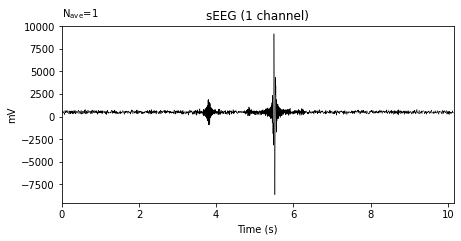

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Using data from preloaded Raw for 1 events and 10151 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Need more than one channel to make topography for seeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10200
    Range : 0 ... 10199 =      0.000 ...    10.199 secs
Ready.
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 45 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 45.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 44.50 Hz)
- Upper passband edge: 55.

<ipython-input-51-9ccaa851a6c6>:17: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs.plot_psd()
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


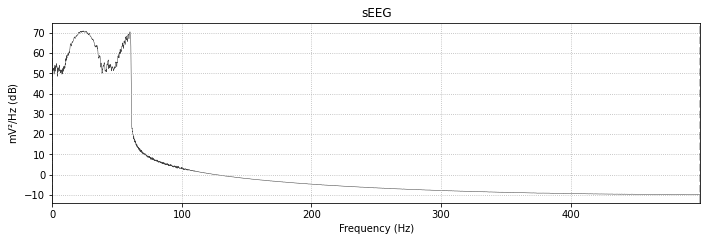

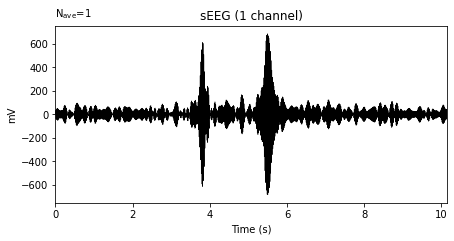

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Using data from preloaded Raw for 1 events and 10151 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Need more than one channel to make topography for seeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10200
    Range : 0 ... 10199 =      0.000 ...    10.199 secs
Ready.
[[ 1.94072189e-17  1.24990165e-02  2.34452604e-02 ...  2.72547609e-02
   1.44771298e-02 -2.60208521e-17]]
10200
[[0 0 0]]
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Need more than one channel to make topography for seeg. Disabling interactivity.


<ipython-input-137-981ddf050b6b>:22: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs.plot_psd()


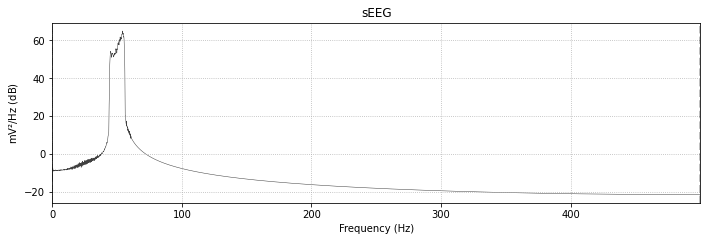

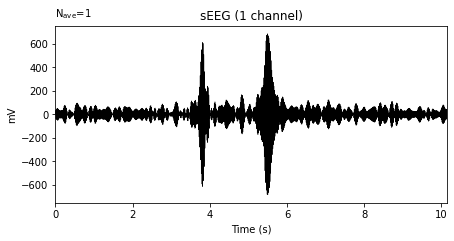

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Using data from preloaded Raw for 1 events and 10151 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Need more than one channel to make topography for seeg. Disabling interactivity.


<ipython-input-51-9ccaa851a6c6>:17: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs.plot_psd()


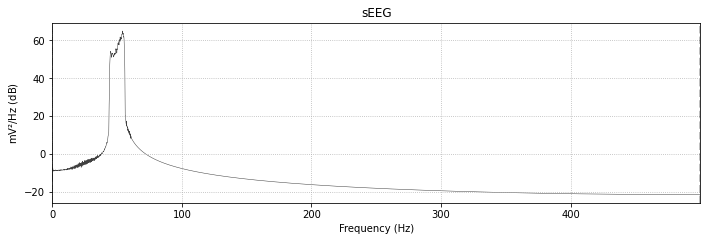

In [137]:
def make_seg_epochs(seg):
    data2=[seg.copy()]
    raw = RawArray(data2, info)
    # print(raw.get_data())
    n_epochs=1
    n_times=len(seg)
    # print(n_times)
    events = np.zeros((n_epochs, 3), dtype=int)
    events[:, 0] = 0
    # print(events)
    epochs = Epochs(raw, events, tmin=0, tmax=(n_times-50) / sfreq,
                    # reject=dict(seeg=4000),
                    baseline=None)
    # print(epochs.get_data())
    fmin=45
    fmax=55
    raw.filter(fmin, fmax, n_jobs=None,  # use more jobs to speed up.
                l_trans_bandwidth=1,  # make sure filter params are the same
                h_trans_bandwidth=1)  # in each band and skip "auto" option.

    epochs.average().plot()
    epochs.plot_psd()
    return raw.get_data()[0]
seg_psd(data[0])
d=data[0].copy()
d=make_seg_epochs(d)
# print(d)
seg_psd(d)

[0.51523677 0.47978764 0.44678745 ... 0.3454898  0.27059741 0.19117311]
Creating RawArray with float64 data, n_channels=1, n_times=10200
    Range : 0 ... 10199 =      0.000 ...    10.199 secs
Ready.
[[0.51523677 0.47978764 0.44678745 ... 0.3454898  0.27059741 0.19117311]]
10200
[[0 0 0]]
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Need more than one channel to make topography for seeg. Disabling interactivity.


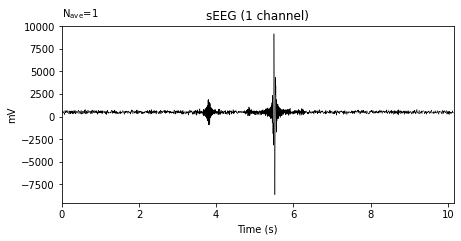

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Using data from preloaded Raw for 1 events and 10151 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Need more than one channel to make topography for seeg. Disabling interactivity.
[1.74108653e-02 1.76170015e-02 1.61412128e-02 ... 1.05385005e-05
 1.03688985e-04 1.65339809e-04]
Creating RawArray with float64 data, n_channels=1, n_times=10200
    Range : 0 ... 10199 =      0.000 ...    10.199 secs
Ready.
[[1.74108653e-02 1.76170015e-02 1.61412128e-02 ... 1.05385005e-05
  1.03688985e-04 1.65339809e-04]]
10200
[[0 0 0]]
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Need more than one channel to make topography for seeg. Disabling interactivity.


<ipython-input-138-9ccaa851a6c6>:17: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs.plot_psd()


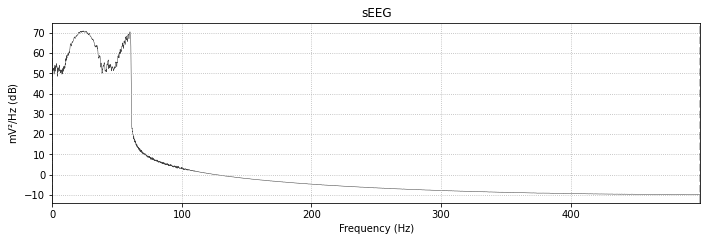

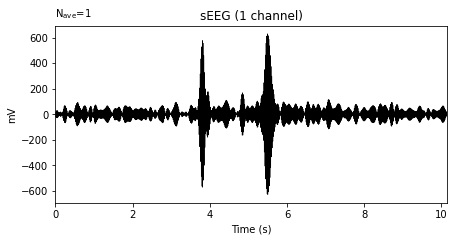

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Using data from preloaded Raw for 1 events and 10151 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Need more than one channel to make topography for seeg. Disabling interactivity.


<ipython-input-138-9ccaa851a6c6>:17: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs.plot_psd()


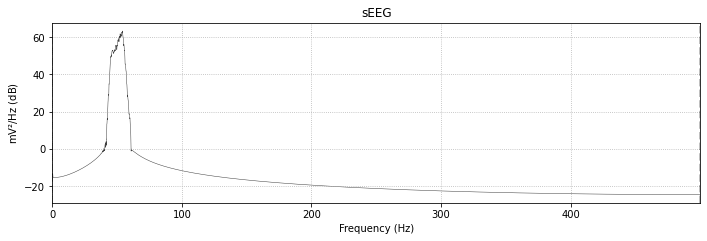

In [138]:

print(data[0])
def seg_psd(seg):
    data2=[seg.copy()]
    raw = RawArray(data2, info)
    print(raw.get_data())
    n_epochs=1
    n_times=len(seg)
    print(n_times)
    events = np.zeros((n_epochs, 3), dtype=int)
    events[:, 0] = 0
    print(events)
    epochs = Epochs(raw, events, tmin=0, tmax=(n_times-50) / sfreq,
                    # reject=dict(seeg=4000),
                    baseline=None)
    # print(epochs.get_data())
    epochs.average().plot()
    epochs.plot_psd()

seg_psd(data[0])
d=data[0].copy()
d=butter_bandpass_filtfilt([45,55],d)
print(d)
seg_psd(d)

## Model fit

In [139]:
def add1(a):
    return a+2
add1(epochs.get_data())


Using data from preloaded Raw for 9 events and 2001 original time points ...
7 bad epochs dropped


array([[[2.68601574, 2.68101653, 2.67111683, ..., 2.47210405,
         2.45578801, 2.43896514]],

       [[2.46493239, 2.46462135, 2.47079702, ..., 2.15349071,
         2.17718376, 2.22907303]]])

In [140]:

def clustering(ievents,algorithm,pipeline=pipeline([])):
    epochs = Epochs(raw, ievents, ievents[0][2], tmin=tmin, tmax=tmax,baseline=None)
    source=epochs.get_data()[:,0] # 原始信号  

    _source=source   # 保存原始信号
    p_source=pipeline(_source)  # 保存新信号
    source=p_source   # 用新的拷贝管道信号
    # 总是用 p 信号聚类。如果不想要管道，输入的时候就设置 pipeline

    best_score = 0
    best_pre = []
    best_cluster_num = 0
    
    if algorithm == 'kmeans':
        # for index, k in enumerate((2,3)):
        for index, k in enumerate((2,)):
            # 选择模型, 默认 Kmeans
            # TimeSeriesKmeans_DTW, DBSCAN, ward, Kmeans
            # model = TimeSeriesKMeans(n_clusters=k, metric="dtw", max_iter=10)
            model=KMeans(n_clusters=k, random_state=666)
            y_pre = model.fit_predict(source)
            print(f'y_pre: {y_pre}')
            score = calinski_harabasz_score(source, y_pre)
            print(f'score: {score}')
            if score > best_score:
                best_score = score
                best_pre = y_pre
                best_cluster_num = k
                best_model=model
    elif algorithm == 'tsdtw':
        # for index, k in enumerate((2,3,4,5,6,7)):
        for index, k in enumerate((2,3)):
            model = TimeSeriesKMeans(n_clusters=k, metric="dtw", max_iter=10)
            y_pre = model.fit_predict(source)
            print(f'y_pre: {y_pre}')
            score = calinski_harabasz_score(source, y_pre)
            print(f'score: {score}')
            if score > best_score:
                best_score = score
                best_pre = y_pre
                best_cluster_num = k
                best_model=model
    elif algorithm == 'dbscan':
        # model = DBSCAN(eps=14, min_samples=2, metric=lambda a, b: DTW(a, b))
        model = DBSCAN(eps=0.3, min_samples=3)
        y_pre = model.fit_predict(source)
        print(f'y_pre: {y_pre}')
        # score = calinski_harabasz_score(source, y_pre)
        score = silhouette_score(source, y_pre)

        print(f'score: {score}')
        if score > best_score:
            best_score = score
            best_pre = y_pre
            best_model=model
    elif algorithm == 'ward':
        model = AgglomerativeClustering(n_clusters = k, linkage = 'ward', metric=DTW)
        y_pre = model.fit_predict(source)
        print(f'y_pre: {y_pre}')
        score = calinski_harabasz_score(source, y_pre)
        print(f'score: {score}')
        if score > best_score:
            best_score = score
            best_pre = y_pre
            best_model=model

    print(f'best_score: {best_score}')
    print(f'best_model: {best_model}')

    source=_source # 取回原始信号, source 默认为原信号，p_source 为拷贝管道后的信号
    model_ans={}
    for i in ('epochs','ievents','source','p_source','best_model','best_pre','best_score'):
        model_ans.update({i:var_from_name(i)})
    return  model_ans
  # model_ans=dict(
  #     best_model=best_model,
  #     best_pre=best_pre,
  #     best_score=best_score,
  #     best_cluster_num=best_cluster_num
  # )



# Ploting 

In [141]:
#@title Function: Print segment by sample location {display-mode: "form"}

# 根据 sample 位置打印前后片段
def print_sample(first_sample):
    _events = np.zeros((1, 3), dtype=int)
    _events[:, 0] = [first_sample]
    _epochs = Epochs(raw, _events, 0, tmin=-1, tmax=1,
                # reject=dict(seeg=4000), 
                baseline=None)
    # epochs.average().plot(title=str(first_sample))
    _epochs.average().plot(titles='segment at sample: '+str(first_sample))


## Plot Clusters

In [142]:
# Muk = best_model.cluster_centers_  # 聚类中心
# C_i = best_model.predict(source)   # 类别列表


def plot_p_clusters(ans):
    ans=ans.copy()
    ans['source']=ans['p_source']
    plot_clusters(ans)

def plot_clusters(ans):
  nSample, nDim = ans['source'].shape
  labs = np.unique(ans['best_pre'])
  means = np.zeros((len(labs),nDim))
  for i, lab in enumerate(labs):
      means[i] = np.mean(ans['source'][ans['best_pre'] == lab], axis=0)
  Muk=means  # 聚类中心
  # print(ans['best_model'])
  if hasattr(ans['best_model'], "labels_"):
      y_pred = ans['best_model'].labels_.astype(int)
  else:
      y_pred = ans['best_model'].predict(X)
  C_i = y_pred  # 类别列表
  print('Events location:')
  print(ans['ievents'])
  # 一次循环
  for original_index,(point,lab) in enumerate(zip(ans['source'],C_i)):
      # print(f'lab={lab}')
      print('label =',lab,', sample location:',ans['ievents'][original_index][0],', segment_head:', point[:3],'original_index:', original_index)
      # print('sample location:',ans['ievents'][original_index][0])
      # print_sample(events[original_index][0])
      # epochs[original_index].plot()
      plt.subplot(Muk.shape[0],1,lab+1)
      plt.plot(np.arange(point.size),point)   # 绘制类内 sample
  for index, (center,lab) in enumerate(zip(Muk,np.unique(C_i))):
      plt.subplot(Muk.shape[0], 1, index+1)
      plt.plot(np.arange(center.size),center,color='red' )   # 红色绘制聚类中心
  plt.show()
  # 打印原始原始片段
  for original_index,(point,lab) in enumerate(zip(ans['source'],C_i)):
      print_sample(ans['ievents'][original_index][0])


# Handle all

In [143]:
# source=epochs.get_data()[:,0]
# print(source)
# ans=clustering(events,var_from_name(algorithm))
# print('---------------')
# print(ans['source'])

# p=pipeline([zscore,downsample(3),bandpass([0,50])])
p=pipeline([zscore,downsample(3),bandpass([0.5,50])]) 

ans=clustering(events,algorithm,p)
plot_clusters(ans)
plot_p_clusters(ans)

Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 9 events and 2001 original time points ...
7 bad epochs dropped
y_pre: [0 1]


ValueError: ignored

In [ ]:
# freqs_times=np.array([[3,4,5,13.3],
            #  [9,10,11,13.2],[6,7,8,13.1],[13,15,17,18],[18,17,20,19]])*sfreq  # 单位 s

freqs_times=np.array([[3,4,5,13],
             [9,10,11,13],[6,7,8,13],[13,15,17,18],[18,19.1,20,19]])*sfreq  # 单位 s

type_id=[0,1,2,3,4]
type_freq_range=[[40,45],[50,60],[60,80],[10,25],[26,27]]  # 单位 Hz
sep_freq_events=[]

# 同频事件：聚出来的频率类分成不同的 event_id，包装到 events 里面。
for (i,lab) in enumerate(type_id):
    # print(freqs_times[i])
    freq_events = np.zeros((len(freqs_times[i]), 3), dtype=int)
    freq_events[:, 0] = freqs_times[i]
    freq_events[:, 2] = type_id[i]
    # print(freq_events)
    if i==0:
        long_events=freq_events.copy()
    else:
        long_events=np.vstack((long_events,freq_events))
    # print(long_events)
    sep_freq_events.append(freq_events)

# print(sep_freq_events)
# print(long_events)

# epochs = Epochs(raw, long_events,tmin=tmin, tmax=tmax,baseline=None)

# 波形分类：对每个同频率的 events 里面进行（滤波）聚类。
for ievents in sep_freq_events:
  # iepochs = Epochs(raw, ievents, ievents[0][2], tmin=tmin, tmax=tmax,baseline=None)
  # print(iepochs)
  # iepochs.get_data()[:,0]
  # source=iepochs.get_data()[:,0]
  # print(iepochs)
  # ans=clustering(ievents,var_from_name(algorithm))
#   p=pipeline([])
# p=pipeline([zscore,downsample(3),bandpass([0,50])])
    p=pipeline([zscore,downsample(6)]) 
    ans=clustering(ievents,algorithm,p)
    plot_clusters(ans)
    plot_p_clusters(ans)
